<a href="https://colab.research.google.com/github/changsin/DeepLearning-101/blob/master/05-word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://github.com/llSourcell/word_vectors_game_of_thrones-LIVE

In [5]:
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [6]:

#encoding. word encodig
import codecs
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print, human readable
import pprint
#regular expressions
import re

In [7]:
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

In [8]:

#stopwords like the at a an, unnecesasry
#tokenization into sentences, punkt 
#http://www.nltk.org/
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:

#get the book names, matching txt file
book_filenames = sorted(glob.glob("*.txt"))

In [12]:
print(book_filenames)

['les_miserables.txt']


In [13]:
#step 1 process data

#initialize rawunicode , we'll add all text to this one bigass file in memory
corpus_raw = u""
#for each book, read it, open it un utf 8 format, 
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'les_miserables.txt'...
Corpus is now 3325128 characters long



In [14]:
#tokenizastion! saved the trained model here
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [15]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [17]:
#convert into list of words
#remove unecessary characters, split into words, no hyhens and shit
#split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [18]:
#for each sentece, sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [19]:
#print an example
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

MADELEINE IN MOURNING

 CHAPTER V—VAGUE FLASHES ON THE HORIZON

 CHAPTER VI—FATHER FAUCHELEVENT

 CHAPTER VII—FAUCHELEVENT BECOMES A GARDENER IN PARIS

 CHAPTER VIII—MADAME VICTURNIEN EXPENDS THIRTY FRANCS ON MORALITY

 CHAPTER IX—MADAME VICTURNIEN’S SUCCESS

 CHAPTER X—RESULT OF THE SUCCESS

 CHAPTER XI—CHRISTUS NOS LIBERAVIT

 CHAPTER XII—M.
['MADELEINE', 'IN', 'MOURNING', 'CHAPTER', 'V', 'VAGUE', 'FLASHES', 'ON', 'THE', 'HORIZON', 'CHAPTER', 'VI', 'FATHER', 'FAUCHELEVENT', 'CHAPTER', 'VII', 'FAUCHELEVENT', 'BECOMES', 'A', 'GARDENER', 'IN', 'PARIS', 'CHAPTER', 'VIII', 'MADAME', 'VICTURNIEN', 'EXPENDS', 'THIRTY', 'FRANCS', 'ON', 'MORALITY', 'CHAPTER', 'IX', 'MADAME', 'VICTURNIEN', 'S', 'SUCCESS', 'CHAPTER', 'X', 'RESULT', 'OF', 'THE', 'SUCCESS', 'CHAPTER', 'XI', 'CHRISTUS', 'NOS', 'LIBERAVIT', 'CHAPTER', 'XII', 'M']


In [20]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 578,851 tokens


In [21]:
#step 2 build our model, another one is Glove
#define hyperparameters

# Dimensionality of the resulting word vectors.
#more dimensions mean more traiig them, but more generalized
num_features = 300

#
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [22]:
text2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [23]:
type(text2vec)

gensim.models.word2vec.Word2Vec

In [ ]:
text2vec.build_vocab(sentences)


In [29]:
print("Word2Vec vocabulary length:", len(text2vec.wv.vocab))

Word2Vec vocabulary length: 11525


In [32]:
#train model on sentneces
text2vec.train(sentences, epochs=10, total_examples=token_count)


(4161292, 5788510)

In [33]:
#save model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [35]:
text2vec.save(os.path.join("trained", "text2vec.w2v"))

In [36]:
text2vec = w2v.Word2Vec.load(os.path.join("trained", "text2vec.w2v"))

In [37]:

#squash dimensionality to 2
#https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [39]:
#put it all into a giant matrix
all_word_vectors_matrix = text2vec.wv.syn0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [40]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [43]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[text2vec.wv.vocab[word].index])
            for word in text2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [44]:
points.head(10)

,word,x,y
0,The,-24.006575,20.569246
1,Project,-4.650750,-66.751450
2,Gutenberg,-4.646818,-66.741501
3,EBook,-36.640976,14.234482
4,of,33.125771,-23.524639
5,Les,-46.762691,27.936632
6,Mis,-36.675285,-7.931233
7,rables,-36.842865,14.196525
8,by,16.176573,11.191626
9,Victor,-37.282967,15.839619


In [45]:
#plot
sns.set_context("poster")

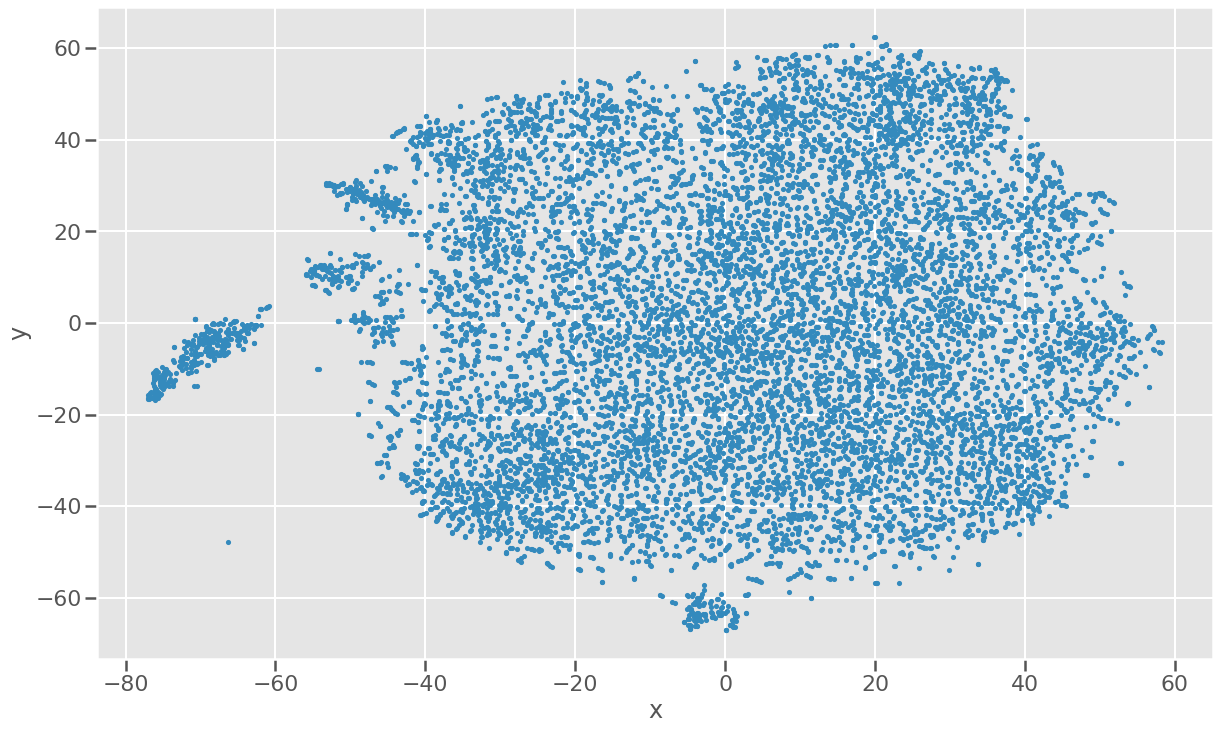

In [46]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [47]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [96]:
#distance, similarity, and ranking
def analogy(start1, end1, end2):
    similarities = text2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {end2} is related to {start2}".format(**locals()))
    return start2

In [103]:
analogy('good', 'fantastic', 'bad')

analogy('Jean', 'Valjean', 'Javert')

good is related to fantastic, as bad is related to ill
Jean is related to Valjean, as Javert is related to Inspector


'Inspector'

In [105]:
text2vec.wv.most_similar("Bishop")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('President', 0.7501416206359863),
 ('inspector', 0.7307651042938232),
 ('director', 0.7279791831970215),
 ('Fleming', 0.71477872133255),
 ('Brevet', 0.6992774605751038),
 ('jury', 0.696345329284668),
 ('usher', 0.6919087767601013),
 ('Scaufflaire', 0.6871194839477539),
 ('Albertine', 0.6862457394599915),
 ('wheelwright', 0.6848663091659546)]